#### Домашняя работа

 1. Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test
---
 2. Для каждого cl_id будет уникальное целевое событие target_flag, а также уникальный канал привлечения клиента channel_type (клиент привлекается лишь однажды и с самого начала его записи присваивается значение канала привлечения)
---
 3. При агрегации (pandas.DataFrame.groupby) по cl_id (или по связке cl_id, channel_type, target_flag) необходимо создавать производные фичи, идеи для таких фичей могут быть следующими:

*	общая сумма транзакций по каждой из trx_category
*	общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)
*	общая сумма транзакций по категориям MCC кодов (например, выбрать основные/популярные MCC коды). ВНИМАНИ! Некоторые MCC коды из train могут быть не представлены в test. Про MCC коды в целом: http://www.banki.ru/wikibank/mcc-kod/; Справочник MCC кодов: https://mcc-codes.ru/code; Про некоторые категории кэшбека Росбанка: https://mcc-codes.ru/card/rosbank-sverkh-plus;
*	возможные агрегации по времени суток и дням недели - траты в выходные (праздники) или будни, в ночное время или в рабочее и т.д.

---

 4. Обязательная часть: провести первичный анализ данных - посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи
---
 5. Дополнительная часть: с отобранными фичами и полученными компонентами обучить модель (тип алгоритма на свой вкус, можно начать с линейной) и померить качество на локальном тестовом наборе данных (локальная валидация), который создается в этом ноутбуке. Метрика оценки качества - ROC AUC(https://en.wikipedia.org/wiki/Receiver_operating_characteristic)

In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import seaborn as sns

sns.set(rc={'figure.figsize':(15,6)})

In [325]:
raw_df = pd.read_csv('rosbank_train.csv')
raw_df = raw_df.drop('target_sum' , axis =1 )
# target_sum - можно выкинуть, переменная участвует в другой задаче

In [326]:
raw_df.head()

#target_flag == 1 (активный клиент)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0


In [327]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 9 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
dtypes: float64(1), int64(4), object(4)
memory usage: 33.7+ MB


# Эксплоративный анализ данных

### Найдем самые популярные MCC

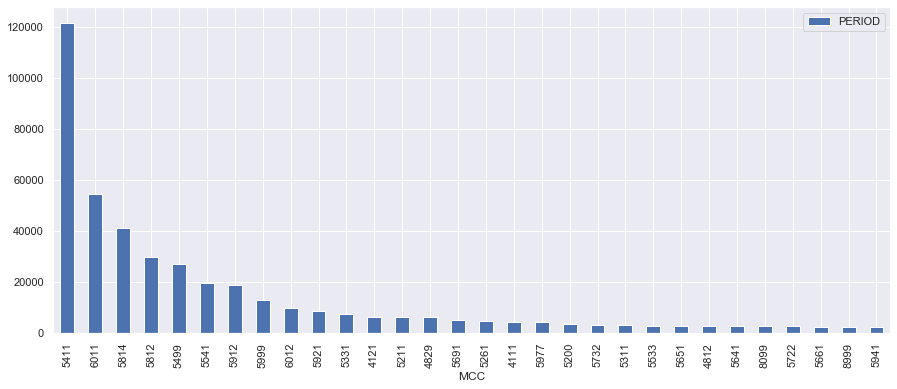

In [216]:
_ = raw_df.groupby(['MCC'])['PERIOD'].count().\
    reset_index().sort_values('PERIOD', ascending = False).head(30).set_index('MCC').plot(kind='bar')

In [217]:
#5411 - Супермаркеты
#6011 - Финансовые учреждения – снятие наличности автоматически
#5814 - Фастфуд
#5812 - Общепит
#5499 - Продовольственные магазины

#### trx_category

In [218]:
np.round(raw_df[raw_df.target_flag == 1]['trx_category'].value_counts()/raw_df['trx_category'].value_counts()*100,1)\
.sort_values()

DEPOSIT           46.7
CASH_ADV          52.9
C2C_IN            54.3
BACK_TRX          59.0
POS               65.6
C2C_OUT           67.3
WD_ATM_ROS        71.2
WD_ATM_PARTNER    71.3
CAT               74.9
WD_ATM_OTHER      89.2
Name: trx_category, dtype: float64

In [219]:
np.round(raw_df['trx_category'].value_counts(normalize = True)*100,1)

POS               84.9
DEPOSIT            4.3
WD_ATM_ROS         3.9
WD_ATM_PARTNER     2.0
C2C_IN             1.5
WD_ATM_OTHER       1.5
C2C_OUT            1.1
BACK_TRX           0.5
CAT                0.2
CASH_ADV           0.0
Name: trx_category, dtype: float64

#### Частоты транзакций

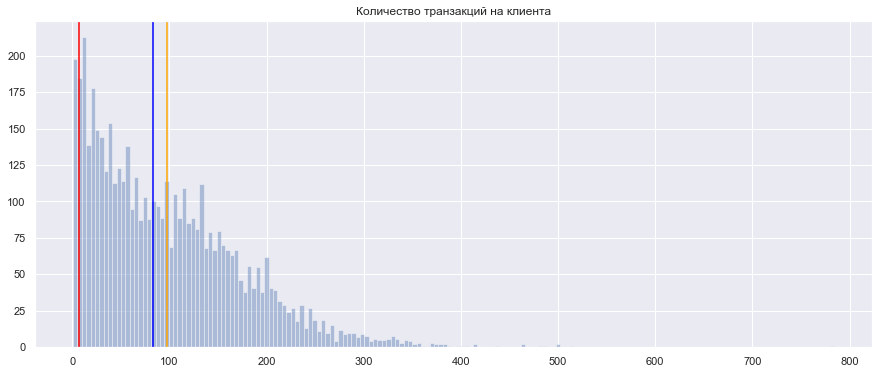

In [220]:
vc = raw_df['cl_id'].value_counts()
sns.distplot(vc.values, bins = 175, kde = False)

plt.title('Количество транзакций на клиента')
plt.axvline(vc.median(), label=f'Медиана: {vc.median()}', color='blue')
plt.axvline(vc.mean(), label=f'Среднее: {vc.mean()}', color='orange')
plt.axvline(vc.mode().values, label=f'Мода: {vc.mode().values[0]}', color='red');

In [221]:
#Много клиентов совершили всего 7 транзакций, однако в основном на клиента приходится по 100 транзакций

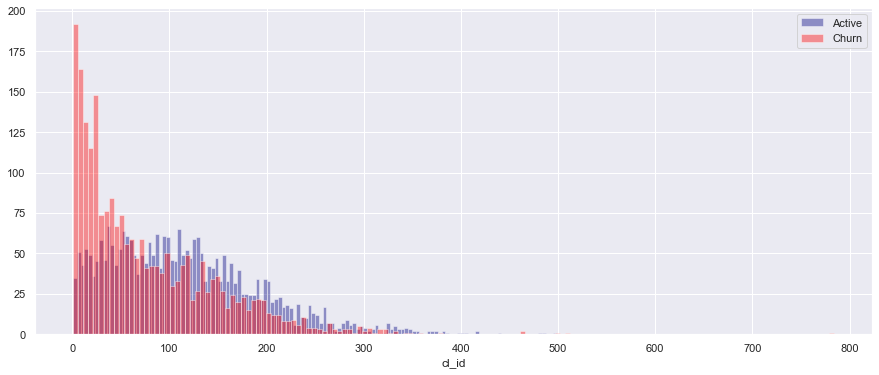

In [222]:
sns.distplot( raw_df[raw_df.target_flag == 1]['cl_id'].value_counts(),\
             bins = 130, kde = False, color="navy", label="Active")
sns.distplot( raw_df[raw_df.target_flag == 0]['cl_id'].value_counts(),\
             bins = 150, kde = False, color="red", label="Churn")
plt.legend();

In [223]:
#по сумме

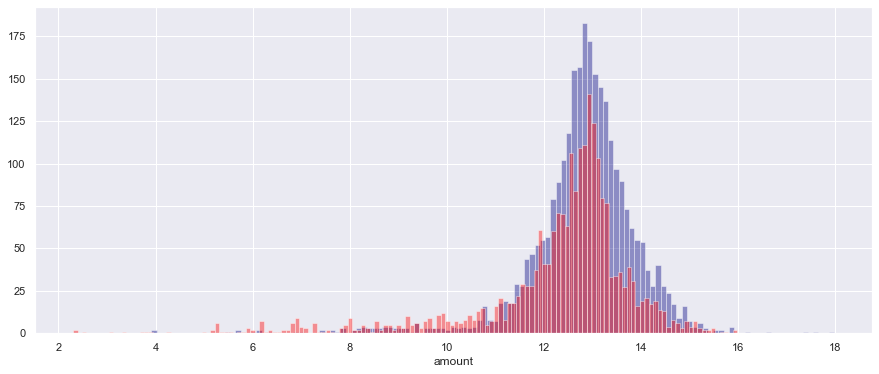

In [224]:
sns.distplot( np.log(raw_df[raw_df.target_flag == 1].groupby('cl_id')['amount'].sum()),\
             bins = 130, kde = False, color="navy", label="Active")
sns.distplot( np.log(raw_df[raw_df.target_flag == 0].groupby('cl_id')['amount'].sum()),\
             bins = 150, kde = False, color="red", label="Churn");

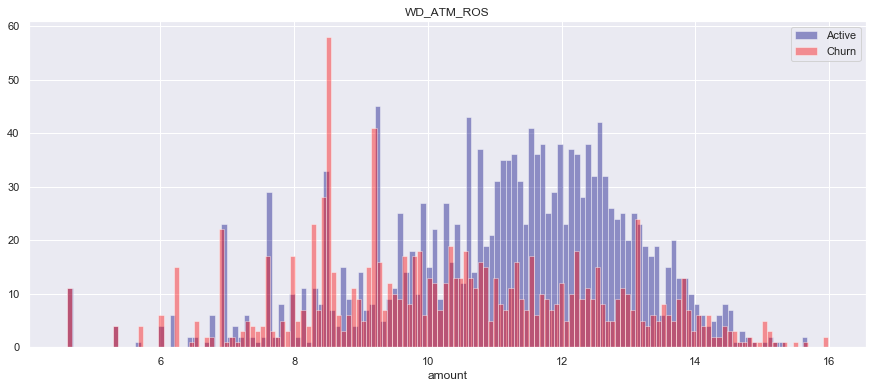

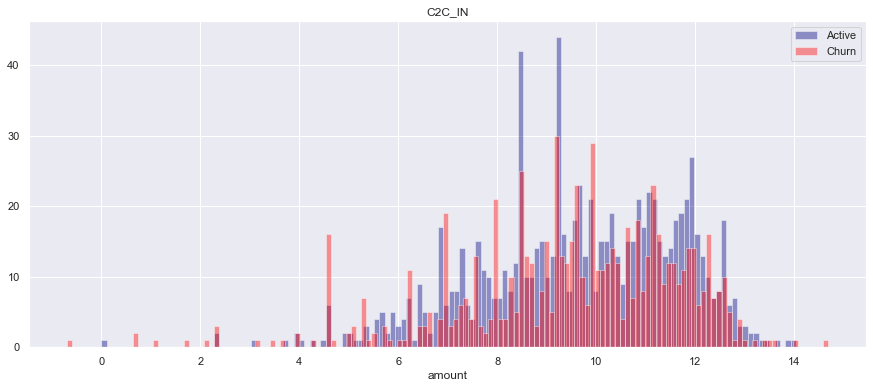

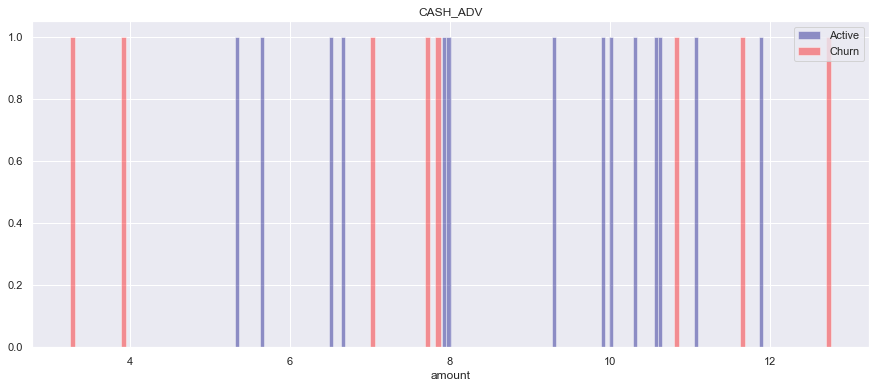

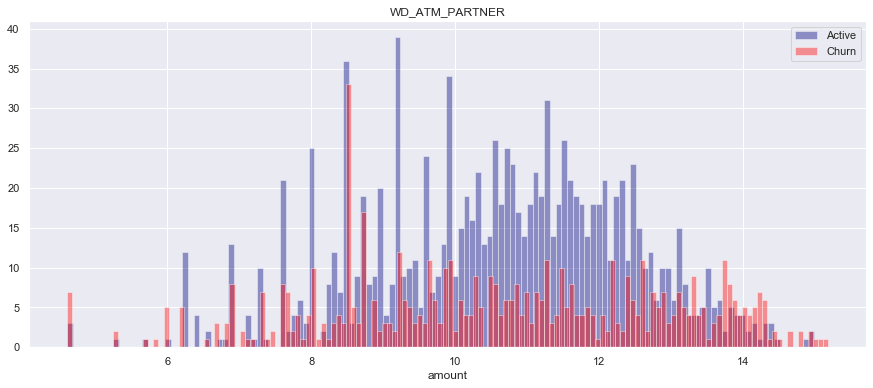

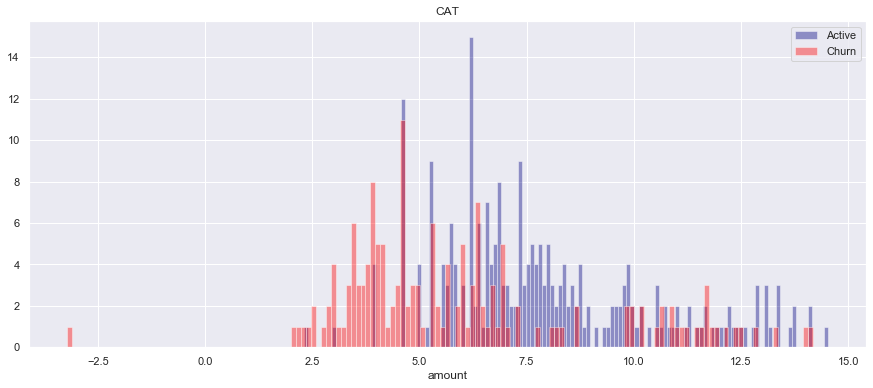

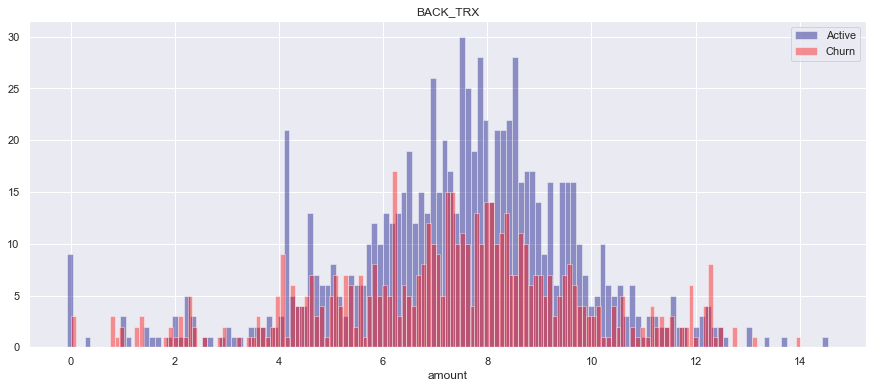

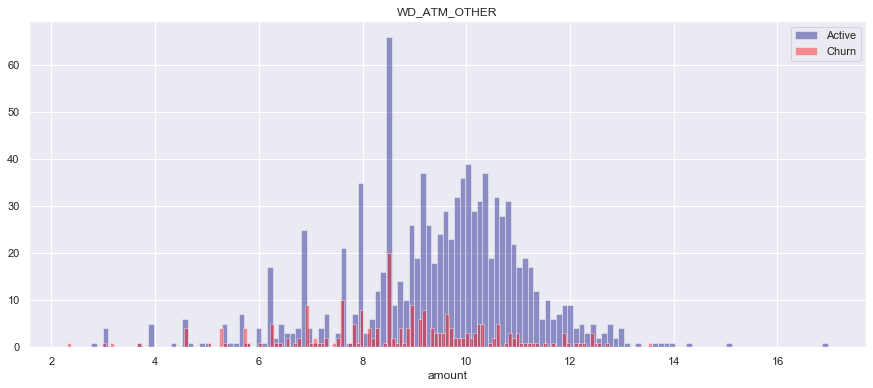

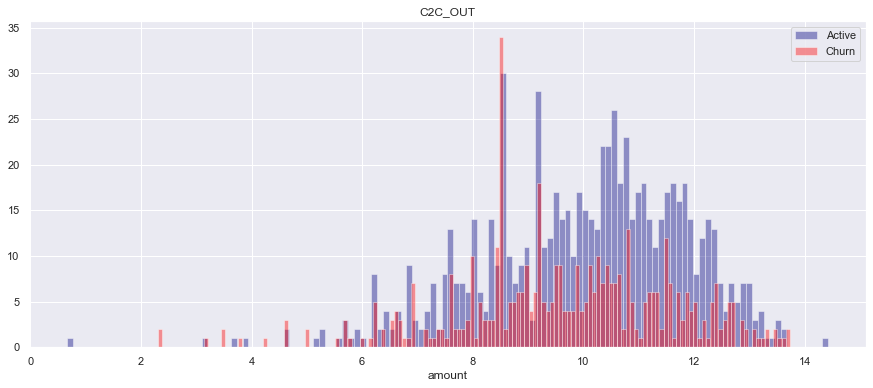

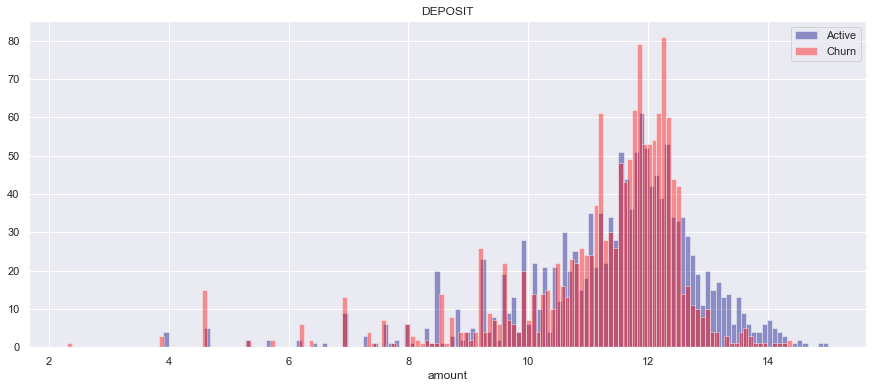

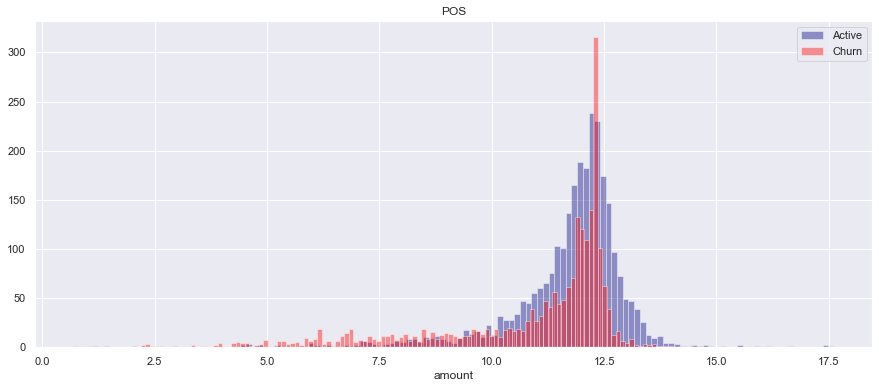

In [225]:
for i, tp in enumerate(set(raw_df['trx_category'])):
    plt.figure(i)
    sns.distplot( np.log(raw_df[(raw_df.target_flag == 1)&(raw_df.trx_category == tp)].groupby('cl_id')['amount'].sum()),\
             bins = 130, kde = False, color="navy", label="Active")
    sns.distplot( np.log(raw_df[(raw_df.target_flag == 0)&(raw_df.trx_category == tp)].groupby('cl_id')['amount'].sum()),\
             bins = 150, kde = False, color="red", label="Churn");
    plt.title(tp)
    plt.legend();

In [226]:
#### Частоты по trx_category

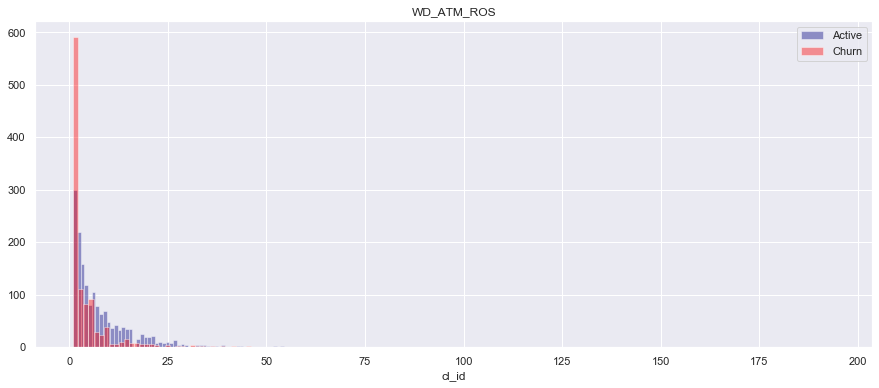

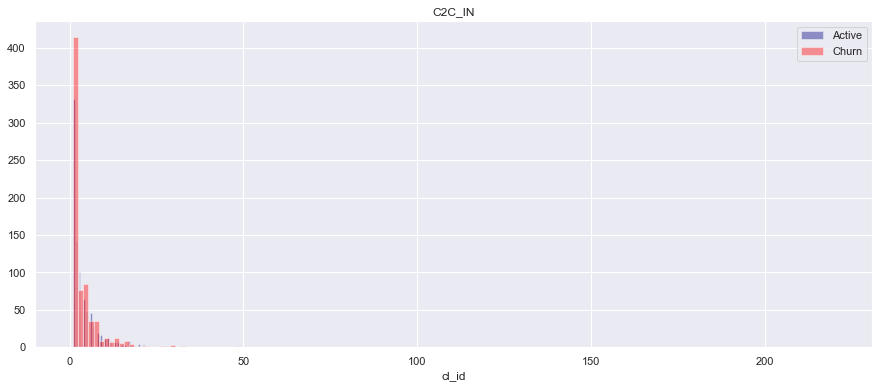

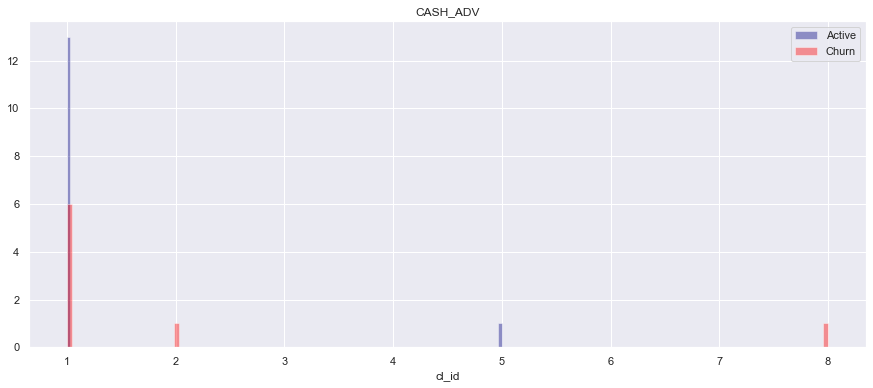

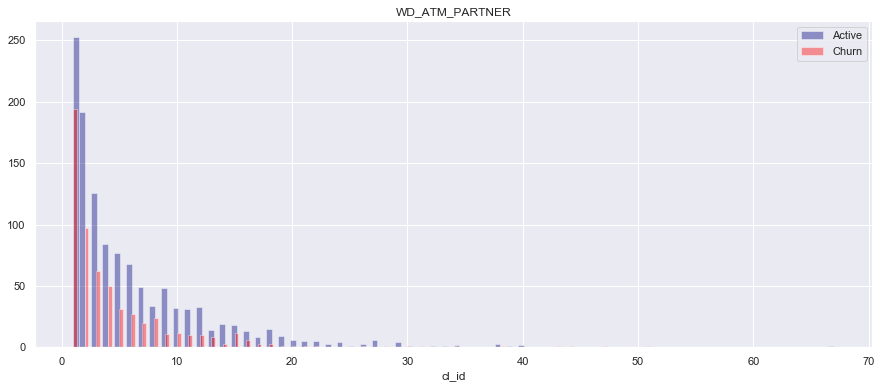

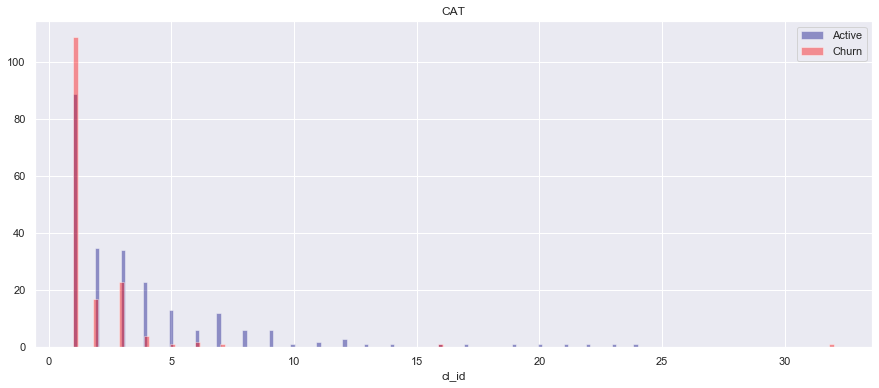

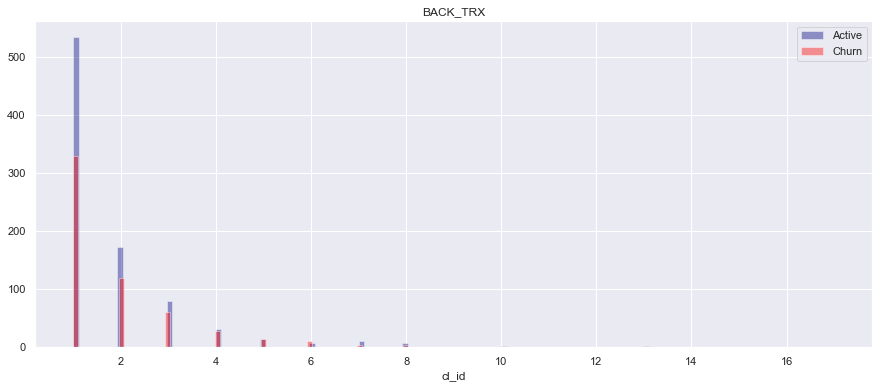

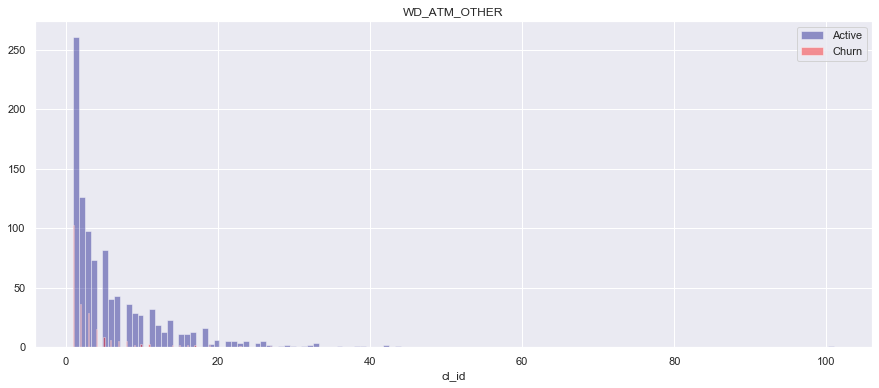

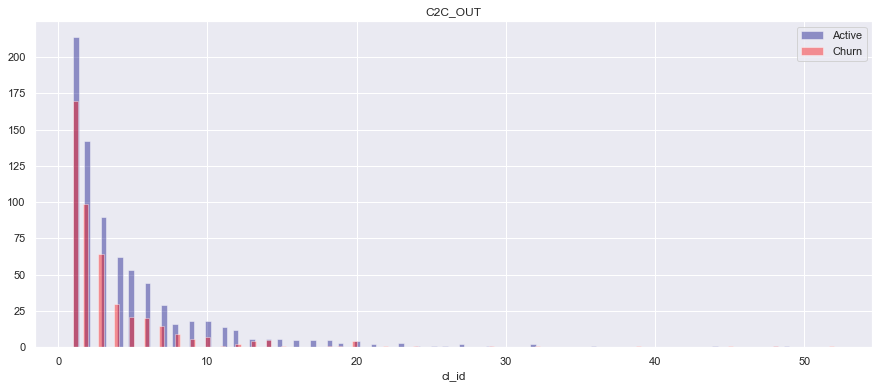

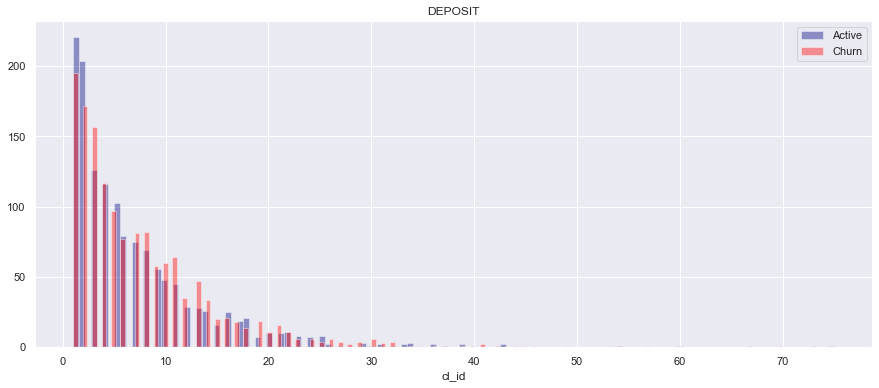

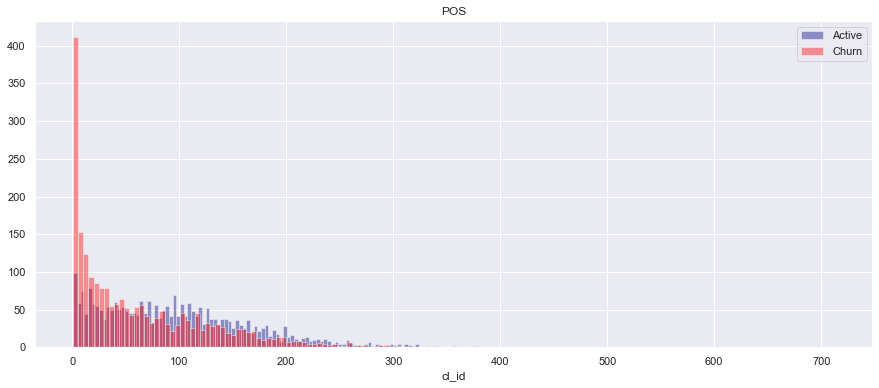

In [227]:
for i, tp in enumerate(set(raw_df['trx_category'])):
    plt.figure(i)
    sns.distplot( raw_df[(raw_df.target_flag == 1)&(raw_df.trx_category == tp)]['cl_id'].value_counts(),\
             bins = 130, kde = False, color="navy", label="Active")
    sns.distplot( raw_df[(raw_df.target_flag == 0)&(raw_df.trx_category == tp)]['cl_id'].value_counts(),\
             bins = 150, kde = False, color="red", label="Churn")
    plt.title(tp)
    plt.legend();

#### Частоты по channel_type

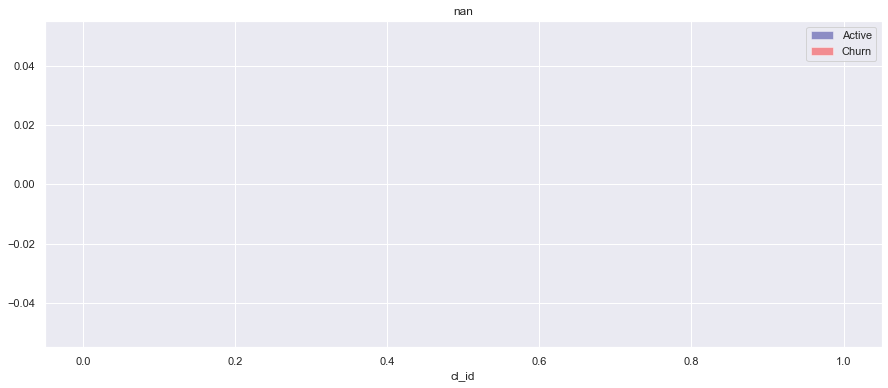

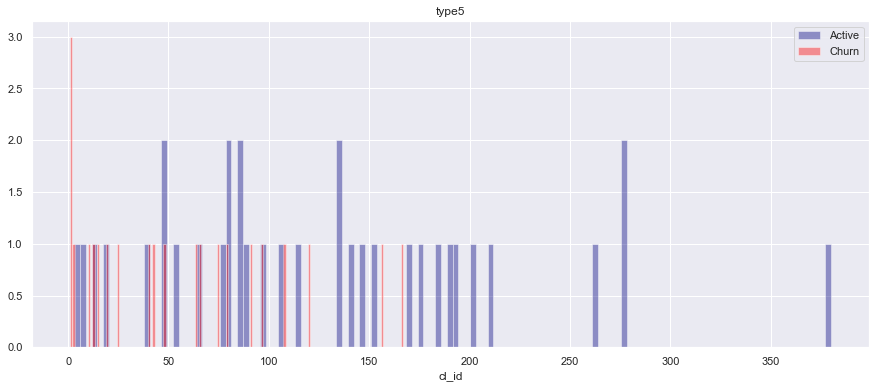

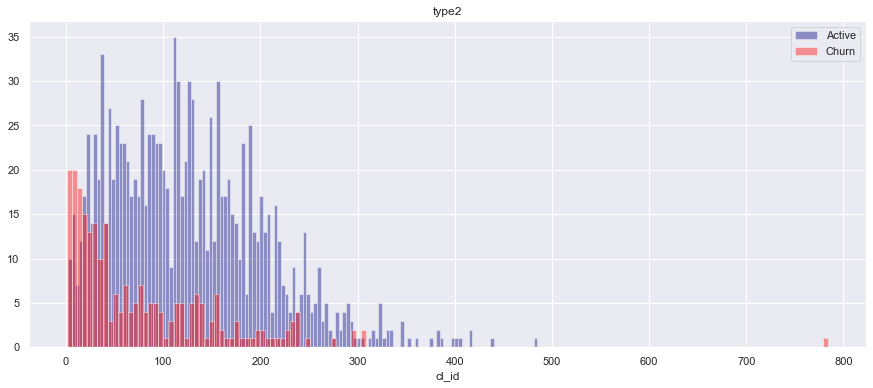

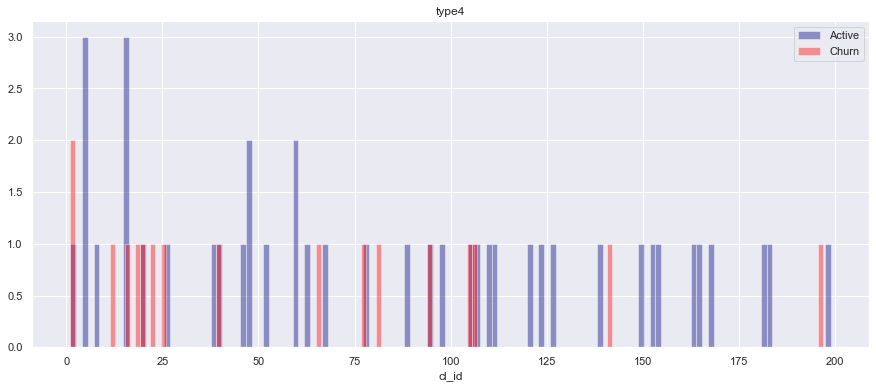

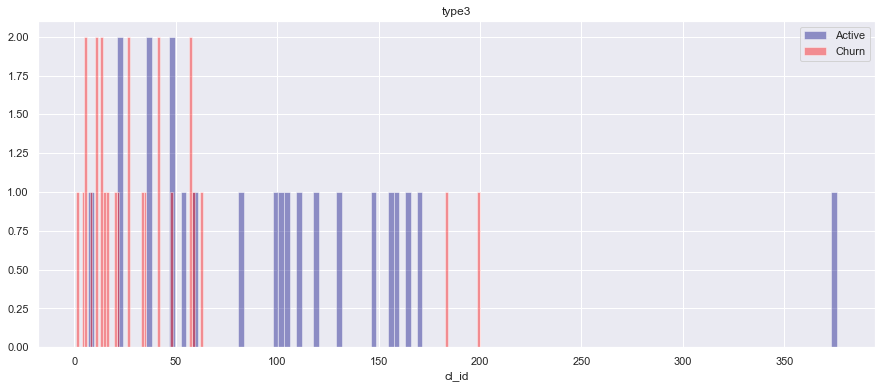

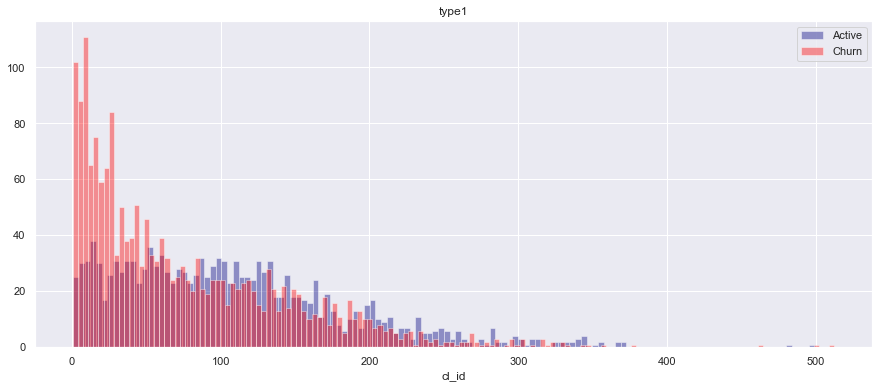

In [228]:
for i, tp in enumerate(set(raw_df['channel_type'])):
    plt.figure(i)
    sns.distplot( raw_df[(raw_df.target_flag == 1)&(raw_df.channel_type == tp)]['cl_id'].value_counts(),\
             bins = 130, kde = False, color="navy", label="Active")
    sns.distplot( raw_df[(raw_df.target_flag == 0)&(raw_df.channel_type == tp)]['cl_id'].value_counts(),\
             bins = 150, kde = False, color="red", label="Churn")
    plt.title(tp)
    plt.legend();

#### Распределение по мсс

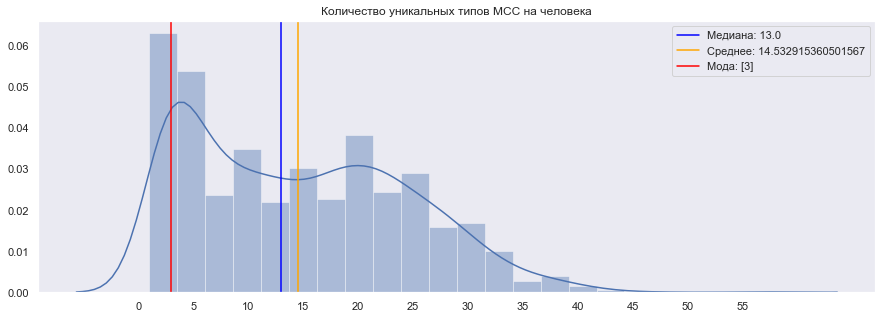

In [229]:
plt.figure(figsize=(15,5))
s = raw_df[raw_df.target_flag == 0].groupby('cl_id').agg({'MCC':'nunique'})
sns.distplot(s)
plt.axvline(s.median().values, label=f'Медиана: {s.median().values[0]}', color='blue')
plt.axvline(s.mean().values, label=f'Среднее: {s.mean().values[0]}', color='orange')
plt.axvline(s.mode().values, label=f'Мода: {s.mode().values[0]}', color='red')
plt.legend()
plt.title('Количество уникальных типов MCC на человека')
plt.grid()
plt.xticks(range(0,60,5), range(0,60,5))
plt.show()

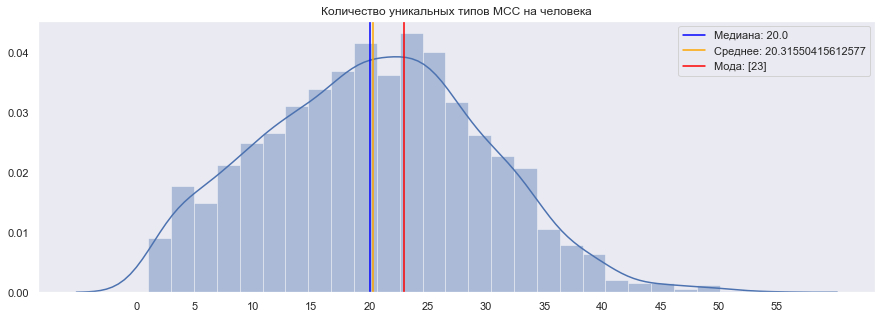

In [230]:
plt.figure(figsize=(15,5))
s = raw_df[raw_df.target_flag == 1].groupby('cl_id').agg({'MCC':'nunique'})
sns.distplot(s)
plt.axvline(s.median().values, label=f'Медиана: {s.median().values[0]}', color='blue')
plt.axvline(s.mean().values, label=f'Среднее: {s.mean().values[0]}', color='orange')
plt.axvline(s.mode().values, label=f'Мода: {s.mode().values[0]}', color='red')
plt.legend()
plt.title('Количество уникальных типов MCC на человека')
plt.grid()
plt.xticks(range(0,60,5), range(0,60,5))
plt.show()

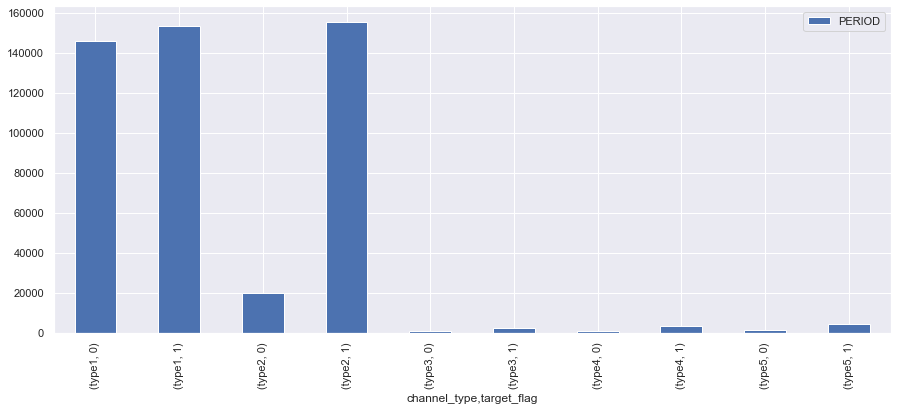

In [231]:
raw_df.groupby(['channel_type','target_flag']).count().iloc[:,:1].plot(kind='bar');

#### Активность по дням недели и времени

In [328]:
raw_df['TRDATETIME_dt'] = pd.to_datetime(raw_df['TRDATETIME'], format='%d%b%y:%H:%M:%S')


raw_df['hour'] = [x.hour for x in raw_df['TRDATETIME_dt']]
raw_df['day'] = [x.day for x in raw_df['TRDATETIME_dt']]
raw_df['month'] = [x.month for x in raw_df['TRDATETIME_dt']]
raw_df['year'] = [x.year for x in raw_df['TRDATETIME_dt']]
raw_df['weekday'] = [x.weekday() for x in raw_df['TRDATETIME_dt']]

raw_df['is_holiday'] = (raw_df['weekday']>=5).astype(int)

In [233]:
raw_df.head(1)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,TRDATETIME_dt,hour,day,month,year,weekday,is_holiday
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,2017-10-21,0,21,10,2017,5,1


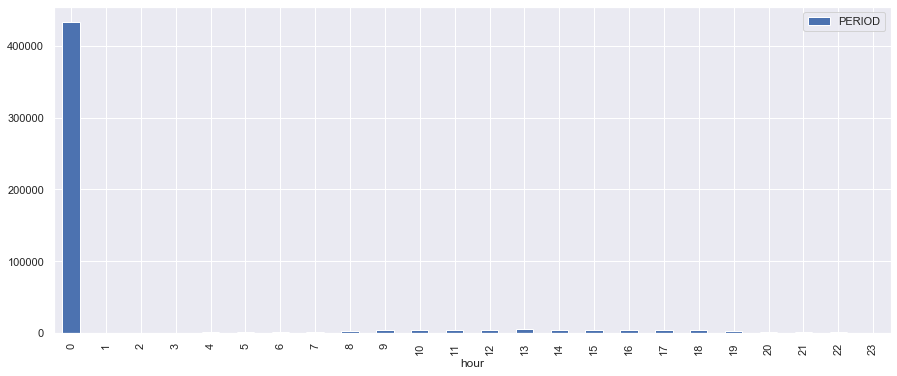

In [234]:
raw_df.groupby('hour').count().iloc[:,:1].plot(kind='bar');

In [235]:
#Большое количество транзакций проходит в 00 часов :(
#Уберем их из графика.

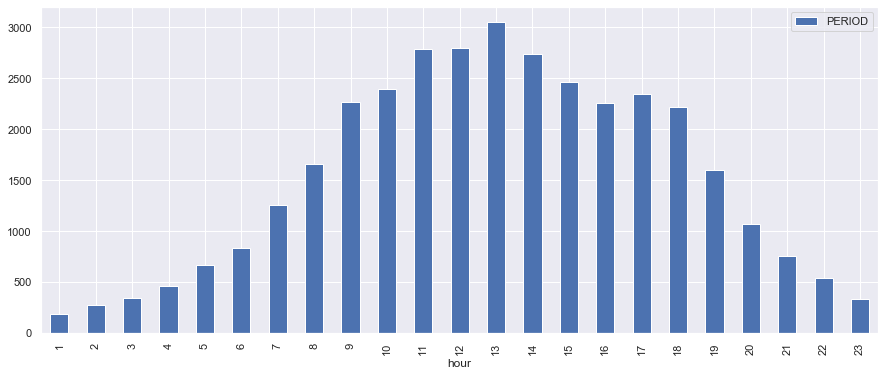

In [236]:
raw_df.query('target_flag == 1').groupby('hour').count().iloc[1:,:1].plot(kind='bar');

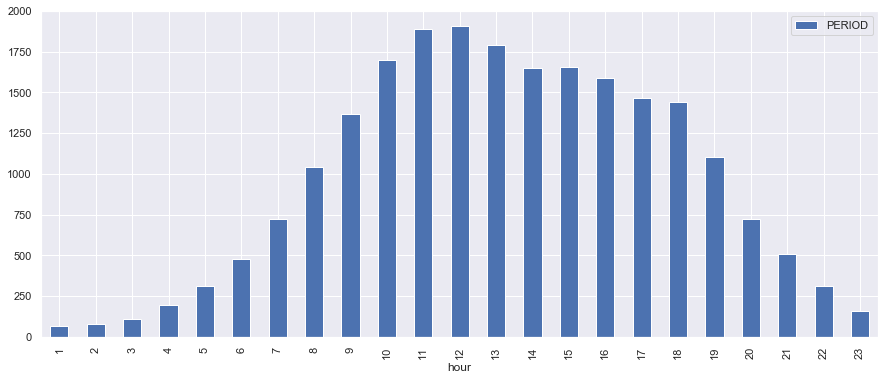

In [237]:
raw_df.query('target_flag == 0').groupby('hour').count().iloc[1:,:1].plot(kind='bar');

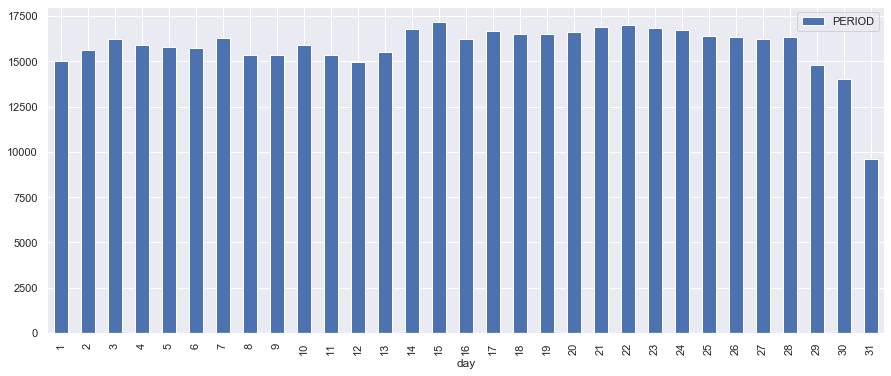

In [238]:
raw_df.groupby('day').count().iloc[:,:1].plot(kind='bar');

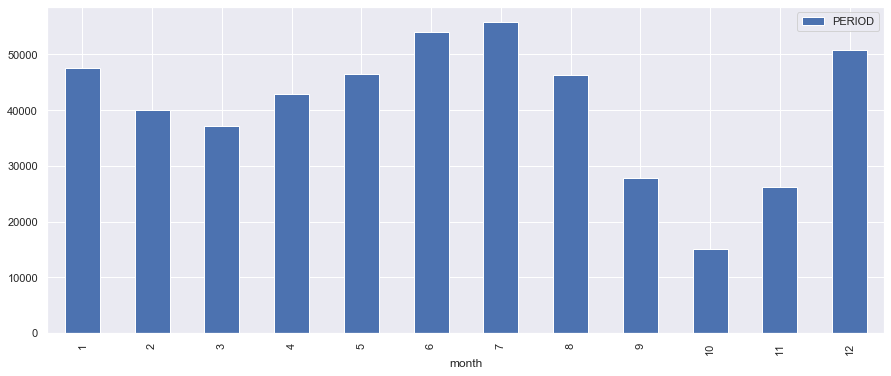

In [239]:
raw_df.groupby('month').count().iloc[:,:1].plot(kind='bar');

## Предобработка данных

In [329]:
raw_df.groupby('cl_id')['target_flag'].mean().mean()

0.5534

##### Всего 5000 клиентов, случайным образом возьмем 1000 клиентов для тестирования

##### Генерация переменных к основному датасету

In [330]:
top_mcc = set(raw_df.groupby(['MCC'])['PERIOD'].count().\
    reset_index().sort_values('PERIOD', ascending = False).head(30)['MCC'])

In [331]:
raw_df['top_mcc'] = raw_df['MCC'].apply(lambda x: True if x in top_mcc else False)

In [332]:
def get_aggregated_df(df, agg_type, col_to_groupby):
    agg_df = df[['cl_id', col_to_groupby, 'amount']].groupby(['cl_id', col_to_groupby]).agg([agg_type])
    agg_df = agg_df.unstack(fill_value=0)
    agg_df.columns = agg_df.columns.get_level_values(2)

    old_name = agg_df.columns.name
    old_cols = agg_df.columns
    new_cols = [old_name + '_' + agg_type + '_' + str(old_col) for old_col in old_cols]
    agg_df.rename(
        columns={old_col: new_col for old_col, new_col in zip(old_cols, new_cols)}, inplace=True
    )
    return agg_df

In [333]:
df_mcc = pd.merge(
    get_aggregated_df(raw_df[raw_df.top_mcc == True], agg_type='count', col_to_groupby='MCC'),
    get_aggregated_df(raw_df[raw_df.top_mcc == False], agg_type='sum', col_to_groupby='MCC'),
    left_index=True,
    right_index=True,
)

In [334]:
df_mcc.shape

(4461, 344)

In [335]:
len(set(raw_df.cl_id))

5000

In [336]:
from dateutil.parser import parse
from datetime import datetime


raw_df['timestamp'] = raw_df['TRDATETIME_dt'].apply(lambda x: int(x.timestamp()))

raw_df = raw_df.merge(raw_df.groupby('cl_id').agg({'timestamp':'max'}).\
                  reset_index().rename(columns = {'timestamp':'max_timestamp'}),
                  on='cl_id', how='outer')

In [251]:
raw_df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,TRDATETIME_dt,hour,day,month,year,weekday,is_holiday,top_mcc,timestamp,max_timestamp
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,2017-10-21 00:00:00,0,21,10,2017,5,1,True,1508544000,1512432000
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,2017-10-12 12:24:07,12,12,10,2017,3,0,True,1507811047,1512432000
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,2017-12-05 00:00:00,0,5,12,2017,1,0,True,1512432000,1512432000
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,2017-10-21 00:00:00,0,21,10,2017,5,1,True,1508544000,1512432000
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,2017-10-24 13:14:24,13,24,10,2017,1,0,True,1508850864,1512432000


In [252]:
rngdate = [365,180,60,30,14,7]

#Находим среднее кол-во операций в день по каждой категории для каждого cl_id за периоды в днях, записанные в rngdate
def count_type_operation(test):
    df = test.groupby('cl_id', as_index = False).\
        agg({'trx_category':'count'}).rename({'trx_category':'count_365'}, axis=1)
    
    for i in rngdate:
        temp = test[test['timestamp'] > test['max_timestamp'] - i*24*60*60].\
        groupby(['cl_id','trx_category'])['trx_category'].size().unstack().fillna(0).reset_index()
        
        temp = temp.filter(items=['cl_id','C2C_OUT','WD_ATM_ROS','DEPOSIT','WD_ATM_OTHER','WD_ATM_PARTNER'])
        tc = [name+str(i) for name in list(temp.columns) if name != 'cl_id']
        tc.insert(0,'cl_id')
        temp.columns = tc
        for col in list(temp.columns):
            if col != 'cl_id':
                temp[col] = temp[col].apply(lambda x: x/i)
    
        df = df.merge(temp, on='cl_id', how='left')

    df = df.drop('count_365', axis=1)
    return df

In [254]:
#Находим среднее кол-во операций в день ВСЕГО для каждого cl_id за периоды в днях, записанные в rngdate
def count_total_operation(test):
    df_count = test.groupby('cl_id', as_index = False).\
            agg({'trx_category':'count'}).rename({'trx_category':'count_365'}, axis=1).drop('count_365',axis=1)
    for i in rngdate:
        temp_count = test[test['timestamp'] > test['max_timestamp'] - i*24*60*60].\
            groupby(['cl_id'])['PERIOD'].count().fillna(0).reset_index().rename(columns={'PERIOD':str(i)})
        
        temp_count[str(i)] = temp_count[str(i)].apply(lambda x: x/i)
        df_count = df_count.merge(temp_count, on='cl_id', how='left')
    return df_count

In [261]:
#count_total_operation(raw_df)
count_type_operation(raw_df)

,cl_id,C2C_OUT365,WD_ATM_ROS365,DEPOSIT365,WD_ATM_OTHER365,WD_ATM_PARTNER365,C2C_OUT180,WD_ATM_ROS180,DEPOSIT180,WD_ATM_OTHER180,...,C2C_OUT14,WD_ATM_ROS14,DEPOSIT14,WD_ATM_OTHER14,WD_ATM_PARTNER14,C2C_OUT7,WD_ATM_ROS7,DEPOSIT7,WD_ATM_OTHER7,WD_ATM_PARTNER7
0,0,0.002740,0.000000,0.002740,0.000000,0.000000,0.005556,0.000000,0.005556,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,0.000000,0.002740,0.005479,0.000000,0.000000,0.000000,0.005556,0.011111,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,5,0.021918,0.038356,0.010959,0.005479,0.005479,0.044444,0.077778,0.022222,0.011111,...,0.142857,0.071429,0.142857,0.000000,0.000000,0.285714,0.000000,0.000000,0.000000,0.000000
3,9,0.000000,0.013699,0.002740,0.000000,0.002740,0.000000,0.027778,0.005556,0.000000,...,0.000000,0.071429,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.142857
4,10,0.052055,0.106849,0.065753,0.000000,0.008219,0.105556,0.216667,0.133333,0.000000,...,0.000000,0.142857,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,11,0.000000,0.000000,0.027397,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,14,0.000000,0.002740,0.000000,0.000000,0.000000,0.000000,0.005556,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,20,0.000000,0.000000,0.008219,0.000000,0.000000,0.000000,0.000000,0.016667,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,21,0.000000,0.000000,0.021918,0.000000,0.000000,0.000000,0.000000,0.044444,0.000000,...,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,22,0.000000,0.002740,0.021918,0.002740,0.005479,0.000000,0.005556,0.044444,0.005556,...,0.000000,0.000000,0.071429,0.000000,0.071429,0.000000,0.000000,0.142857,0.000000,0.142857


In [337]:
count_operation_df = count_type_operation(raw_df).merge(count_total_operation(raw_df), how='inner', on='cl_id')

In [338]:
count_operation_df.shape

(5000, 37)

##### Создадим новую фичу - общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)

In [263]:
def val_amount(dataset):
    return dataset.query("currency == 810 | currency == 978 | currency == 840").groupby(['cl_id','currency'])\
    ['amount'].sum().unstack().fillna(0).\
    reset_index().rename(columns={810:'rub_amount',840:'dol_amount',978:'euro_amount'})

In [284]:
val_amount(raw_df).shape

(4999, 4)

##### Собираем финальный датафрейм

In [339]:
final_df = count_operation_df.merge(val_amount(raw_df), how = 'outer', on = 'cl_id')

In [340]:
final_df.shape

(5000, 40)

In [149]:
#####

In [341]:
final_df = final_df.merge(df_mcc, how = 'inner', on = 'cl_id')

In [342]:
final_df.head()

,cl_id,C2C_OUT365,WD_ATM_ROS365,DEPOSIT365,WD_ATM_OTHER365,WD_ATM_PARTNER365,C2C_OUT180,WD_ATM_ROS180,DEPOSIT180,WD_ATM_OTHER180,...,MCC_sum_8675,MCC_sum_8699,MCC_sum_8911,MCC_sum_8931,MCC_sum_9211,MCC_sum_9222,MCC_sum_9311,MCC_sum_9399,MCC_sum_9402,MCC_sum_9405
0,1,0.000000,0.002740,0.005479,0.000000,0.000000,0.000000,0.005556,0.011111,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,210.0,0.0,0.0,0.0
1,5,0.021918,0.038356,0.010959,0.005479,0.005479,0.044444,0.077778,0.022222,0.011111,...,0.0,0.0,0.0,0.0,0.0,3825.0,0.0,0.0,0.0,0.0
2,9,0.000000,0.013699,0.002740,0.000000,0.002740,0.000000,0.027778,0.005556,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10,0.052055,0.106849,0.065753,0.000000,0.008219,0.105556,0.216667,0.133333,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11,0.000000,0.000000,0.027397,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [343]:
final_df.shape

(4461, 384)

In [157]:
#####

In [290]:
final_df.columns.values

array(['cl_id', 'C2C_OUT365', 'WD_ATM_ROS365', 'DEPOSIT365',
       'WD_ATM_OTHER365', 'WD_ATM_PARTNER365', 'C2C_OUT180',
       'WD_ATM_ROS180', 'DEPOSIT180', 'WD_ATM_OTHER180',
       'WD_ATM_PARTNER180', 'C2C_OUT60', 'WD_ATM_ROS60', 'DEPOSIT60',
       'WD_ATM_OTHER60', 'WD_ATM_PARTNER60', 'C2C_OUT30', 'WD_ATM_ROS30',
       'DEPOSIT30', 'WD_ATM_OTHER30', 'WD_ATM_PARTNER30', 'C2C_OUT14',
       'WD_ATM_ROS14', 'DEPOSIT14', 'WD_ATM_OTHER14', 'WD_ATM_PARTNER14',
       'C2C_OUT7', 'WD_ATM_ROS7', 'DEPOSIT7', 'WD_ATM_OTHER7',
       'WD_ATM_PARTNER7', '365', '180', '60', '30', '14', '7',
       'rub_amount', 'dol_amount', 'euro_amount', 'MCC_count_4111',
       'MCC_count_4121', 'MCC_count_4812', 'MCC_count_4829',
       'MCC_count_5200', 'MCC_count_5211', 'MCC_count_5261',
       'MCC_count_5311', 'MCC_count_5331', 'MCC_count_5411',
       'MCC_count_5499', 'MCC_count_5533', 'MCC_count_5541',
       'MCC_count_5641', 'MCC_count_5651', 'MCC_count_5661',
       'MCC_count_5691', 'MCC_cou

In [161]:
#####

In [162]:
#тут эксперименты

In [344]:
final_df = final_df.merge(raw_df.groupby('cl_id').target_flag.unique().\
                              apply(lambda x: x[0]).to_frame().reset_index(), on='cl_id', how='inner')

In [295]:
#final_df = final_df.drop('cl_id', axis = 1)

In [293]:
final_df.head()

,cl_id,C2C_OUT365,WD_ATM_ROS365,DEPOSIT365,WD_ATM_OTHER365,WD_ATM_PARTNER365,C2C_OUT180,WD_ATM_ROS180,DEPOSIT180,WD_ATM_OTHER180,...,MCC_sum_8699,MCC_sum_8911,MCC_sum_8931,MCC_sum_9211,MCC_sum_9222,MCC_sum_9311,MCC_sum_9399,MCC_sum_9402,MCC_sum_9405,target_flag
0,1,0.000000,0.002740,0.005479,0.000000,0.000000,0.000000,0.005556,0.011111,0.000000,...,0.0,0.0,0.0,0.0,0.0,210.0,0.0,0.0,0.0,0
1,5,0.021918,0.038356,0.010959,0.005479,0.005479,0.044444,0.077778,0.022222,0.011111,...,0.0,0.0,0.0,0.0,3825.0,0.0,0.0,0.0,0.0,1
2,9,0.000000,0.013699,0.002740,0.000000,0.002740,0.000000,0.027778,0.005556,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,10,0.052055,0.106849,0.065753,0.000000,0.008219,0.105556,0.216667,0.133333,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,11,0.000000,0.000000,0.027397,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [319]:
abs(final_df.corr()['target_flag']).sort_values()

MCC_sum_5399         0.000099
MCC_sum_8211         0.000219
MCC_sum_5571         0.000756
MCC_sum_8011         0.001128
MCC_sum_3026         0.001682
MCC_sum_8351         0.001933
dol_amount           0.001972
MCC_count_6012       0.002043
MCC_sum_3655         0.002059
MCC_sum_7992         0.002083
MCC_sum_4789         0.002129
MCC_sum_5013         0.002211
MCC_sum_3355         0.002352
MCC_sum_3530         0.002456
MCC_sum_5733         0.002484
MCC_sum_1711         0.002683
MCC_count_5211       0.002760
MCC_sum_5131         0.003122
MCC_sum_7321         0.003335
C2C_OUT7             0.003510
MCC_sum_4215         0.003602
MCC_sum_7261         0.003789
MCC_sum_5122         0.003993
MCC_count_8999       0.004150
MCC_sum_5099         0.004301
MCC_sum_8241         0.004512
MCC_sum_5198         0.004665
MCC_sum_5713         0.004985
MCC_sum_4011         0.005082
MCC_sum_5950         0.005294
                       ...   
DEPOSIT30            0.114312
rub_amount           0.116160
MCC_count_

#### Отбор переменных

In [345]:
import scipy as sc

all_corr_col = []

for col in set(final_df.columns):
    if abs(sc.stats.pointbiserialr(final_df['target_flag'], final_df[col])[0]) >=0.05:
        all_corr_col.append(col)

In [346]:
all_corr_col.remove('target_flag')

In [347]:
all_corr_col

['MCC_sum_7523',
 'WD_ATM_OTHER60',
 'rub_amount',
 'WD_ATM_PARTNER60',
 'MCC_count_4111',
 'MCC_count_5541',
 'WD_ATM_ROS14',
 'MCC_count_4121',
 '7',
 'WD_ATM_ROS60',
 'MCC_count_5812',
 'WD_ATM_OTHER7',
 'cl_id',
 '180',
 'MCC_count_5661',
 'WD_ATM_PARTNER30',
 'WD_ATM_PARTNER180',
 '365',
 'WD_ATM_OTHER14',
 'DEPOSIT14',
 'DEPOSIT30',
 'DEPOSIT7',
 'MCC_count_5912',
 'MCC_count_5411',
 'WD_ATM_PARTNER365',
 'MCC_count_5499',
 'DEPOSIT180',
 'MCC_sum_5611',
 'DEPOSIT60',
 'MCC_count_5331',
 'MCC_count_6011',
 'WD_ATM_OTHER30',
 'WD_ATM_OTHER365',
 'MCC_count_5691',
 'WD_ATM_PARTNER14',
 'MCC_count_5941',
 'MCC_count_4812',
 '60',
 'WD_ATM_OTHER180',
 'WD_ATM_ROS365',
 'MCC_count_5999',
 'DEPOSIT365',
 'C2C_OUT365',
 'C2C_OUT60',
 '30',
 '14',
 'WD_ATM_ROS180',
 'WD_ATM_ROS30',
 'MCC_sum_7230',
 'MCC_sum_5655',
 'MCC_sum_5699',
 'MCC_count_5814',
 'C2C_OUT180',
 'MCC_sum_9399',
 'MCC_sum_7832',
 'MCC_count_5921']

### Разделим на трейн и тест.  Обучим модель.

In [348]:
cl_ids_test = np.random.choice(raw_df.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)

In [360]:
cl_ids_test_set = set(cl_ids_test).intersection(set(final_df.cl_id))

In [354]:
len(cl_ids_test_set)

899

In [381]:
# create transactions dataset for train
transactions_train = final_df[~final_df.cl_id.isin(cl_ids_test_set)].copy()
print("Total client in train dataset: ", len(transactions_train))
# create transactions dataset for test
transactions_test = final_df[final_df.cl_id.isin(cl_ids_test_set)].copy()
print("Total client in test dataset: ", len(transactions_test))

Total client in train dataset:  3562
Total client in test dataset:  899


In [383]:
y_train = transactions_train.target_flag
X_train = transactions_train[all_corr_col].drop(['cl_id'], axis = 1)

y_test = transactions_test.target_flag
X_test = transactions_test[all_corr_col].drop(['cl_id'], axis = 1)

In [366]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve

In [385]:
clf = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=0)\
.fit(X_train, y_train)

In [386]:
y_train_predict = clf.predict_proba(X_train)[:, 1]


roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
print("Train: ", roc_auc_train)

Train:  0.97


In [ ]:
Train:  0.94
Test:  0.82

In [387]:
y_test_predict = clf.predict_proba(X_test)[:, 1]


roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Test: ", roc_auc_test)

Test:  0.82


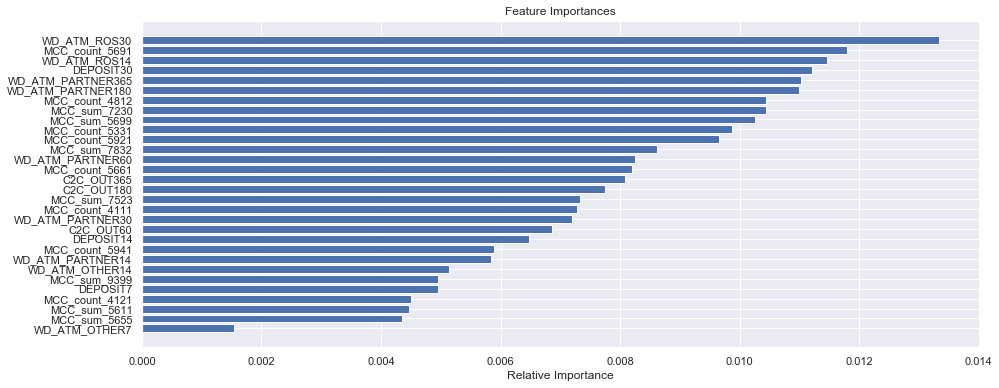

In [389]:
features = X_train.columns
importances = clf.feature_importances_

indices = np.argsort(importances)[:30]

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()